# Shortest Path Problem LP formulation
[Murwan Siddig](mailto:msiddig@clemson.edu)

------------------------------------------------------------------------

\begin{align*}
\min_{\text{s.t.}} \ & \sum_{i=1}^{N} \sum_{j=1}^{N} c_{ij}x_{ij}  \\
 & \sum_{j=1}^N x_{ij} - \sum_{j=1}^N x_{ji} = 0 \ , \ \forall \ i \neq s \ \, ,\ i \neq d\\ 
 & \sum_{j=1}^N x_{sj} - \sum_{j=1}^N x_{js} = 1 \\ 
 & \sum_{j=1}^N x_{dj} - \sum_{j=1}^N x_{jd} = -1\\ 
 & x_{ij} \geq 0 \ , \ \forall \ i=1, \dots N , \ j=1,\dots N\\ 
\end{align*}
Assume $s = 1$ and $d = N$ 

In [1]:
#technical lines
using CSV;
using DataFrames;
using LightGraphs;
using GraphPlot;
using JuMP;
using Gurobi;
const GRB_ENV = Gurobi.Env();

Academic license - for non-commercial use only


In [2]:
#reading the problem data to Julia
data = CSV.read("Ex3_data.csv", DataFrame);

#converting the DataFrame-type variable (data) to a Matrix
c = convert(Matrix{Float64}, data);

#specifying the problem data
N = size(data)[1];
s=1;
d=N;

#########################################
Ex_3 = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0));
@variable(Ex_3,x[1:N,1:N]>=0);
@objective(Ex_3, Min, sum(sum(c[i,j]*x[i,j] for i=1:N) for j=1:N));
for i=1:N
    if i != s && i != d
        @constraint(Ex_3, sum(x[i,j] for j=1:N)-sum(x[j,i] for j=1:N) == 0);
    elseif i == s
        @constraint(Ex_3, sum(x[i,j] for j=1:N)-sum(x[j,i] for j=1:N) == 1);
    elseif i == d
        @constraint(Ex_3, sum(x[i,j] for j=1:N)-sum(x[j,i] for j=1:N) == -1);
    end
end
optimize!(Ex_3);
status = termination_status(Ex_3);
obj_value = objective_value(Ex_3);
x_value = value.(x);
println("=======================================")
println("=======================================")
println("Status = ", status)
println("Optimal objective value = ", obj_value)

Status = OPTIMAL
Optimal objective value = 2728.43182


# Shortest Path (Cont): National Parks

Consider a directed graph $D = (\mathcal{N}, \mathcal{A})$, where:
* $\mathcal{N}$, nodes representing the 46 national parks in the United States.
* $\mathcal{A}$, arcs representing the Euciledian Distance between park $i$ and $j$ for every pair $(i,j) \in \mathcal{A}$

\begin{align*}
\min_{\text{s.t.}} \ & \sum_{(i,j) \ \in \ \mathcal{A}} c_{i,j}x_{i,j}  \\
 & \sum_{j \ \in \ O(i)} x_{ij} + \sum_{j \ \in  \ I(i)} x_{ji} = b_i \ , \ \forall \ i \ \in \ \mathcal{N} \\ 
 & x_{ij} \geq 0 \ , \ \forall \ (i,j) \ \in \ \mathcal{A}  \\ 
\end{align*}
where

$
\begin{array}{cccc}
& b_s & = &  1 & \\
& b_d & = & -1 & \\
& b_i & = & 0 & \forall \ i \neq s \ , \ i\neq d \\
\end{array}
$

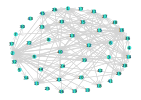

In [3]:
#initializing an adjacency Matrix
adj = zeros(N,N);
for i=1:N
    for j=1:N 
        #for the sake of presentation only add arcs which have values smaller than 2800
        if c[i,j] > 0 && c[i,j] > 3000
            adj[i,j] = 1
        end
    end
end
#Define a directed Graph using the adjacency list
NatPark = DiGraph(adj);

#Numbering the nodes
node_label = [1:nv(NatPark)]
gplot(NatPark,layout=stressmajorize_layout, nodelabel=node_label[1])

In [4]:
max_arc = 1100;

In [5]:
#Given a starting_city and destination_city what is the shortest path?
function All_Shortest_paths(distances,starting_city,destination_city)
    c = distances;
    s=starting_city;
    d=destination_city;
    #########################################
    SP = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0));
    @variable(SP, x[i=1:N,j=1:N; 0<=c[i,j]<=max_arc]>=0);
    @objective(SP, Min, sum(sum(c[i,j]*x[i,j] for i=1:N if 0<=c[i,j]<=max_arc) for j=1:N));
    for i=1:N
        if i != s && i != d 
            @constraint(SP, sum(x[i,j] for j=1:N if 0<=c[i,j]<=max_arc)-sum(x[j,i] for j=1:N if 0<=c[j,i]<=max_arc) == 0);
        elseif i == s
            @constraint(SP, sum(x[i,j] for j=1:N if 0<=c[i,j]<=max_arc)-sum(x[j,i] for j=1:N if 0<=c[j,i]<=max_arc) == 1);
        elseif i == d
            @constraint(SP, sum(x[i,j] for j=1:N if 0<=c[i,j]<=max_arc)-sum(x[j,i] for j=1:N if 0<=c[j,i]<=max_arc) == -1);
        end
    end
    optimize!(SP);
    status = termination_status(SP);
    obj_value = objective_value(SP);
    x_value = value.(x);
    status, obj_value, x_value
end

All_Shortest_paths (generic function with 1 method)

In [6]:
solutions = [];
distances = c;
#Use the function to find the shortest path between every pair of parks
for s=1:N
    for d=1:N
        if s!=d
            starting_city = s
            destination_city = d
            status, obj_value, x_value = All_Shortest_paths(distances,starting_city,destination_city);
            push!(solutions,[(s,d),status,obj_value,x_value])
        end
    end
end

In [7]:
#Rearranging the data for the output
p = [];
distances = zeros(N,N)
paths = Array{Any,2}(undef,N,N);
for k=1:length(solutions)
temp = zeros(N,N);
    for i=1:N
        for j=1:N
            if 0<=c[i,j]<=max_arc
                temp[i,j] = solutions[k][4][i,j]
            end
        end
    end
    solutions[k][4] = temp
end

for s=1:N
    for d=1:N
        if s != d
            indx = findfirst(x -> (s,d)==x[1], solutions)
            city = s;
            cost = 0;
            Route = [];
            check = findfirst(x -> x >= 1-1e-6 && 0<=x<=max_arc, c[s,:])
            while true 
                push!(Route,city);
                next = findfirst(x -> x >= 1-1e-6, solutions[indx][4][city,:])
                if next == nothing 
                    break
                end
                local_cost = c[city,next];
                cost += local_cost
                city = next;
                
                if city == d
                    push!(Route,city);
                    break
                end
            end
            push!(Route,d);
            distances[s,d] = cost;
            paths[s,d] = Route;
        end
    end
end
distances = distances.*0.621371;
push!(p,distances);
push!(p,paths);

In [8]:
RawData = CSV.read("data.csv", DataFrame); 
names = RawData[!,1];
names = convert(Array{String}, names);
# Pretty Print function
function printDistanceandPath(start,dest)
    s=findfirst(x -> x == start ,names)
    d=findfirst(x -> x == dest ,names)
    println("s =", s)
    println("d = ", d)
    if s==nothing
        println("Invalid starting point")
        return
    end
    
    if d==nothing
        println("Invalid destination")
        return
    end
    
    indx = findfirst(x -> (s,d)==x[1], solutions)
    
   println("The shortest path from ",names[s]," to ",names[d]," is:")
   for i in p[2][s,d]
        println(" => ", names[i])
    end
    println("The path is ",p[1][s,d]," miles long.")
end

printDistanceandPath (generic function with 1 method)

In [9]:
printDistanceandPath(names[rand(1:length(names))],names[rand(1:length(names))])

s =29
d = 33
The shortest path from Mammoth Cave to Olympic is:
 => Mammoth Cave
 => Hot Springs
 => Carlsbad Caverns *
 => Bryce Canyon
 => Great Basin
 => Mount Rainier
 => Olympic
 => Olympic
The path is 2609.588770458745 miles long.
